# Python Project №1: *Three Triple Simple Moving Average Algorthm (TTSMA) for Commodities trading*

## Made by Vladislav Gusev

-------------------------

## №1. Algorithm specification and implementation

**Baseline paper:** *Walugembe, Francis and Stoica, Tiberiu, Evaluating Triple Moving Average Strategy Profitability Under Different Market Regimes (September 2021). ResearchGate (2021), Available at SSRN: https://ssrn.com/abstract=4185701*

**Additional recouses:**
1) https://datasciencedrivein.medium.com/three-way-moving-average-trading-strategy-no-short-selling-required-w-python-code-1a7940a46ac1


2) https://www.youtube.com/watch?v=rO_cqa4x60o

In [117]:
#!pip install ttrpy
#!pip install pandas-datareader
#!pip install mpl_finance
#!pip install --upgrade mplfinance

In [321]:
import pandas as pd

from ttrpy.trend.sma import sma

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import talib
from sklearn.cluster import KMeans
from pandas_datareader import data as web
import scipy.spatial.distance
from datetime import datetime as dt
from matplotlib.ticker import FuncFormatter
pd.options.mode.chained_assignment = None

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Triple Simple Moving Average (TSMA) was designed for short-term trading and it
smooths price fluctuations while filtering out volatility, hence identifying trends
with the lag associated with moving averages. The TSMA equation is a composite
of a single simple moving average, a double simple moving average, and a triple
simple moving average.


**TSMA=3 * SMA(p, n) - 3 * SMA(SMA(p, n), n) + SMA(SMA(SMA(p, n), n), n)**

What is mean by **Three** SMAs is that usually there are chosen 3 distinct time periods for calculations. Due to the fact that our data will be daily, we have to pick 3 intervals that will reflect short-lower, short-middle, and short-upper dynamics of the commodity. In the baseline paper time intervals of 10, 30 and 50 days were chosen. We will use different intervals to match short-term needs. 

In [322]:
#Calculation of the TSMA:
def tsma(df, price, tsma, n):
    """
    Parameters:
        df (pd.DataFrame): DataFrame which contain the asset price.
        price (string): the column name of the price of the asset.
        tsma (string): the column name for the n-day double exponential moving average results.
        n (int): the total number of periods.
    Returns:
        df (pd.DataFrame): Dataframe with n-day double exponential moving average of the asset calculated.
    """

    df = sma(df, price, tsma + "_sma", n)
    df = sma(df[n - 1 :], tsma + "_sma", tsma + "_sma_2", n)
    df = sma(df[n - 1 :], tsma + "_sma_2", tsma + "_sma_3", n)
    df[tsma] = (
        3 * df[tsma + "_sma"] - 3 * df[tsma + "_sma_2"] + df[tsma + "_sma_3"]
    )
    df = df.dropna().reset_index(drop=True)
    df.drop(
        [tsma + "_sma", tsma + "_sma_2", tsma + "_sma_3"], axis=1, inplace=True
    )

    return df

-----------------

Let's load the data to estimate initial parameters and plot necessary graphs. We use data on Nickel prices from 2016 to 2023. In the test sample there is only data between 2016 and 2021. 

In [323]:
dta = pd.read_csv('nickel_train.csv')
dates = dta['Date']
dta.drop(columns=['Change %', 'Date', 'Vol.'],inplace = True)
dates = pd.to_datetime(dates)
dta['Date'] = dates

In [324]:
df_6 = tsma(dta, 'Price', 'tsma6', 6)
df_21 = tsma(dta, 'Price', 'tsma21', 21)
df_45 = tsma(dta, 'Price', 'tsma45', 45)

dta['Short'] = df_6['tsma6']
dta['Middle'] = df_21['tsma21']
dta['Long'] = df_45['tsma45']

cross_buy = ((dta['Short'] > dta['Long']) & (dta['Middle'] > dta['Long'])) & ((dta['Short'].shift() < dta['Long'].shift()) | (dta['Middle'].shift() < dta['Long'].shift()))
cross_sell = (dta['Short'] < dta['Middle']) | (dta['Short'] < dta['Long']) 

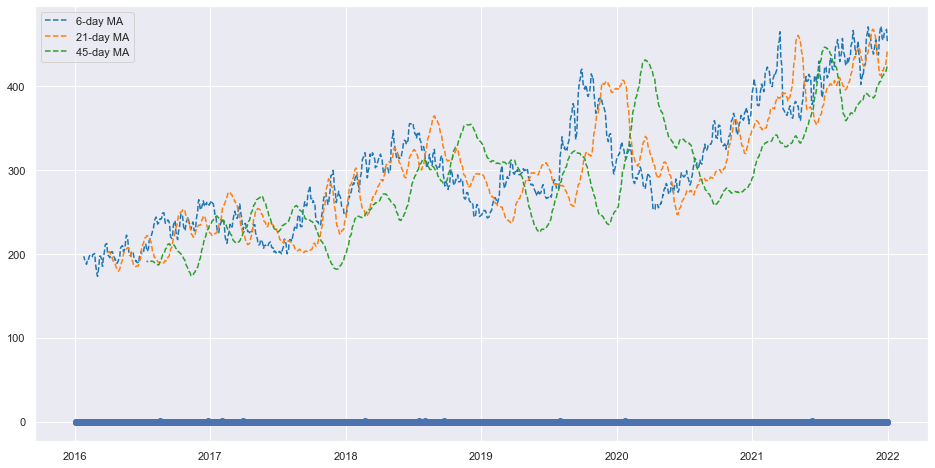

In [325]:
# Plot the averages

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the moving averages
ax.plot(dates, dta['Short'], color='tab:blue', label='6-day MA', linestyle='--')
ax.plot(dates, dta['Middle'], color='tab:orange', label='21-day MA', linestyle='--')
ax.plot(dates, dta['Long'], color='tab:green', label='45-day MA', linestyle='--')
plt.scatter(dates, cross_buy)
ax.legend()
None

In [326]:
#Let us create more consistent trading strategy

def functio(data):
    buying = [np.nan] * len(data)  # Initialize with NaNs
    selling = [np.nan] * len(data)  # Initialize with NaNs
    sign_long = False
    sign_short = False
    
    for i in range(1, len(data)):
        if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and not sign_long: 
            buying[i] = data['Price'][i]
            sign_long = True
        elif sign_long and data['Short'][i] > data['Middle'][i]:
            selling[i] = data['Price'][i]
            sign_long = False
        elif data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and not sign_short:
            buying[i] = data['Price'][i]
            sign_short = True
        elif sign_short and data['Short'][i] > data['Middle'][i]:
            selling[i] = data['Price'][i]
            sign_short = False
            
    return buying,selling
buy = functio(dta)[0]
sell = functio(dta)[1]

dta['Buy'] = buy
dta['Sell'] = sell

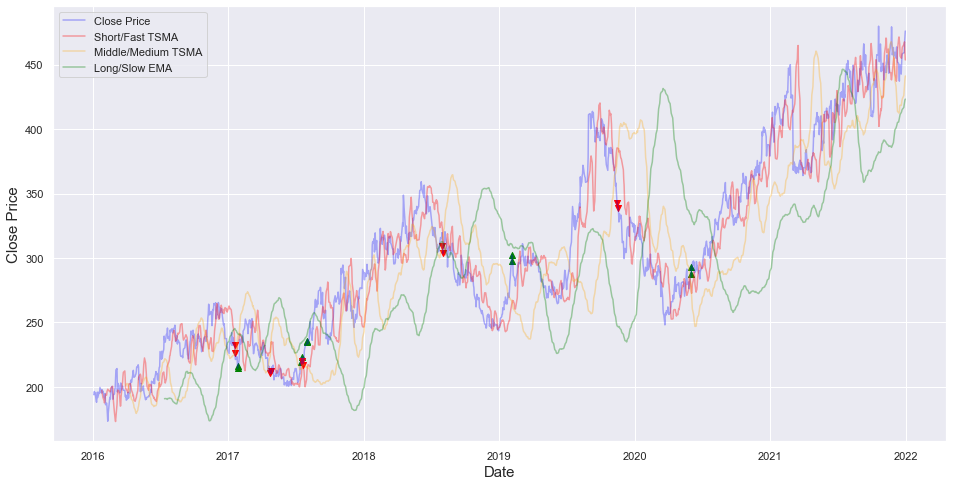

In [327]:
dta['Date'] = pd.to_datetime(dta['Date'])

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(dta['Date'], dta['Price'], label='Close Price', color='blue',alpha=0.3) 
ax.plot(dta['Date'], dta['Short'], label='Short/Fast TSMA', color='red', alpha=0.35) 
ax.plot(dta['Date'], dta['Middle'], label='Middle/Medium TSMA', color='orange', alpha = 0.3) 
ax.plot(dta['Date'], dta['Long'], label='Long/Slow EMA', color='green', alpha = 0.35)
ax.scatter(dta['Date'], dta['Buy'], color='green', marker='^', alpha=1)
ax.scatter(dta['Date'], dta['Sell'], color='red', marker='v', alpha=1)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend()
plt.show()

---------------

## №2.1 Backtesting

We have now calculated everything that is needed for the trading strategy. We have an unknown for the model test sample. We will predict it using ARIMA model. 

In [328]:
test = pd.read_csv("nickel_test.csv")
dates = test['Date']
test.drop(columns=['Change %', 'Date', 'Vol.'],inplace = True)
dates = pd.to_datetime(dates)
test['Date'] = dates

test_ts = test['Price']
train_ts = dta['Price']

arima = ARIMA(train_ts, order=(0, 1, 1))
arima_fit = arima.fit()

future_forecast = arima_fit.forecast(steps=len(test_ts))

In [329]:
test['Price_Generic'] = test['Price']
test['Price'] = future_forecast.values

In [330]:
df_5 = tsma(test, 'Price', 'tsma5', 5)
df_10 = tsma(test, 'Price', 'tsma10', 10)
df_20 = tsma(test, 'Price', 'tsma20', 20)

test['Short'] = df_5['tsma5']
test['Middle'] = df_10['tsma10']
test['Long'] = df_20['tsma20']

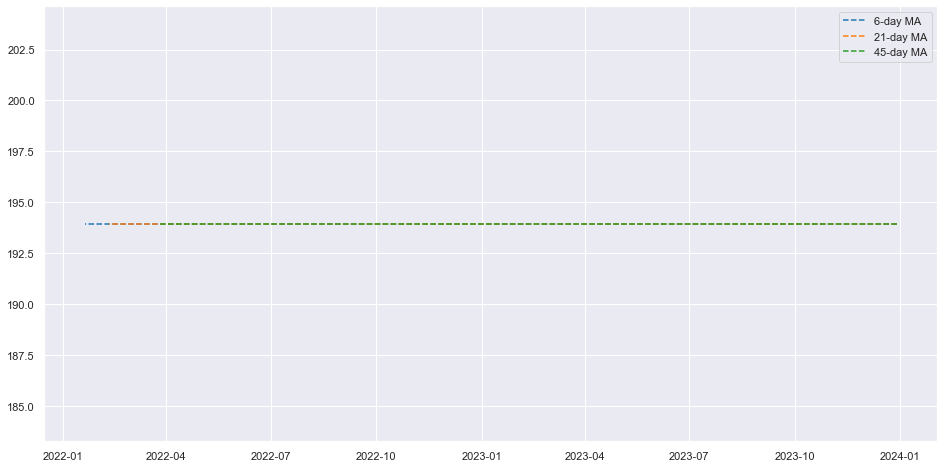

In [331]:
# Plot the averages

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the moving averages
ax.plot(dates, test['Short'], color='tab:blue', label='6-day MA', linestyle='--')
ax.plot(dates, test['Middle'], color='tab:orange', label='21-day MA', linestyle='--')
ax.plot(dates, test['Long'], color='tab:green', label='45-day MA', linestyle='--')
ax.legend()
None

**Conclusion:** ARIMA did not give forecast for the future prices to calculate the moving averages. That is why it is impossible to backtest the strategy with this method.

### Attempt №2

We will just calculate the returns with the given methodology on the test sample. There is no way to predict 500 values knowing 1500. We have to move data by 500, so that the train data will be only 2 times larger than the train. Moreover, we do not have any exogenous variables to correctily predict.

**We will use backtest on the train sample**

In [334]:
signals = pd.DataFrame(columns=['Type', 'Date', 'Price'])
first_buy_signal = False

for date, row in dta.iterrows():
    if cross_buy.loc[date] and not first_buy_signal:
        first_buy_signal = True
        new_signal = pd.DataFrame({'Type': ['Buy'], 'Date': [date], 'Price': [row['Low']]})
        signals = pd.concat([signals, new_signal], ignore_index=True)
    elif cross_sell.loc[date] and first_buy_signal:
        first_buy_signal = False
        new_signal = pd.DataFrame({'Type': ['Sell'], 'Date': [date], 'Price': [row['High']]})
        signals = pd.concat([signals, new_signal], ignore_index=True)


signals.reset_index(drop=True, inplace=True)

# 2. Calculate the returns for each trade
signals['Returns'] = np.nan

for i in range(0, len(signals) - 1, 2):
    buy_price = signals.iloc[i]['Price']
    sell_price = signals.iloc[i + 1]['Price']
    signals.iloc[i + 1, signals.columns.get_loc('Returns')] = sell_price - buy_price - 0.001 * sell_price

# 3. Calculate the metrics
total_net_profit = signals['Returns'].sum()
profit_factor = signals[signals['Returns'] > 0]['Returns'].sum() / abs(signals[signals['Returns'] < 0]['Returns'].sum())
percent_profitable = len(signals[signals['Returns'] > 0]) / (len(signals) / 2) * 100
average_trade_net_profit = signals['Returns'].mean()
drawdown = (signals['Price'].cummax() - signals['Price']).max()

#VaR
alpha = 0.05
sorted_returns = signals['Returns'].sort_values()
var = sorted_returns.quantile(alpha)

#ES
es = sorted_returns[sorted_returns <= var].mean()

print(f"Total Net Profit: {total_net_profit:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Percent Profitable: {percent_profitable:.2f}%")
print(f"Average Trade Net Profit: {average_trade_net_profit:.2f}")
print(f"Maximum Drawdown: {drawdown:.2f}")
print("Value-at-Risk (VaR) at", alpha, "confidence level:", var)
print("Expected Shortfall (ES) at", alpha, "confidence level:", es)

Total Net Profit: 85.98
Profit Factor: 4.70
Percent Profitable: 90.00%
Average Trade Net Profit: 8.60
Maximum Drawdown: 188.74
Value-at-Risk (VaR) at 0.05 confidence level: -11.82097150000001
Expected Shortfall (ES) at 0.05 confidence level: -23.252380000000013


**Conclusion:** These results can be interpolated into $20.000.000 initial capital. As for the Maximum dropdown, it is exteremly high in comparison to the total net profit, that is why this strategy does not hold the backtest conditions